# Numerical Simulations of Matrix Estimation

## Overview

This notebook implements numerical simulations to verify matrix estimation properties based on linear algebra operations. We examine relationships between ground truth matrices (A, B) and their estimators (hat_A, hat_B) under noise perturbations.


## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, List

np.random.seed(42)  # For reproducibility

## Simulation Parameters

In [2]:
# Matrix dimensions
N_ROWS_A = 15    # Rows in matrix A
M_COLS_A = 13    # Columns in matrix A
P_COLS_B = 14    # Columns in matrix B
Q_ROWS_B = 12    # Rows in matrix B

# Experiment parameters
NUM_OBSERVATIONS = 100000  # Number of observations
NOISE_STD = 1            # Standard deviation of noise

## Matrix Generation Functions

### Create Ground Truth Matrix A

In [3]:
def create_matrix_A(n: int, m: int, scale: int=2) -> np.ndarray:
    """Create matrix A with L1-normalized rows.
    
    Args:
        n: Number of rows
        m: Number of columns
        
    Returns:
        Matrix A of shape (n, m) with normalized rows
    """
    A = scale * np.random.rand(n, m)
    return(A / A.sum(axis=1, keepdims=True))

### Create Ground Truth Matrix B

In [4]:
def create_matrix_B(q: int, p: int, scale: int=2) -> np.ndarray:
    """Create random matrix B.
    
    Args:
        q: Number of rows
        p: Number of columns
        
    Returns:
        Random matrix B of shape (q, p)
    """
    return scale * np.random.rand(q, p)

### Create Design Matrices

In [5]:
def create_design_matrices(m: int, q: int, num_obs: int) -> List[np.ndarray]:
    """Generate design matrices X_t.
    
    Args:
        m: Number of rows (matches A columns)
        q: Number of columns (matches B rows)
        num_obs: Number of time steps
        
    Returns:
        List of random matrices X_t with shape (m, q)
    """
    return [np.random.rand(m, q) for _ in range(num_obs)]

### Create Noise Matrices


In [6]:
def create_noise_matrices(n: int, p: int, num_obs: int, noise_std: float) -> List[np.ndarray]:
    """Generate Gaussian noise matrices E_t.
    
    Args:
        n: Number of rows (matches A rows)
        p: Number of columns (matches B columns)
        num_obs: Number of time steps
        noise_std: Standard deviation of noise
        
    Returns:
        List of noise matrices E_t with shape (n, p)
    """
    return [np.random.normal(loc=0, scale=noise_std, size=(n, p)) for _ in range(num_obs)]

### Generate Complete Dataset

In [7]:
def generate_dataset(
    n: int, m: int, p: int, q: int, num_obs: int, noise_std: float
) -> Tuple[np.ndarray, np.ndarray, List[np.ndarray], List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """Generate complete dataset with all components.
    
    Returns:
        A: Ground truth matrix A
        B: Ground truth matrix B
        X_list: Design matrices [X_1,...,X_T]
        E_list: Noise matrices [E_1,...,E_T]
        M_list: Signal matrices [A X_t B]
        Y_list: Observation matrices [A X_t B + E_t]
    """
    A = create_matrix_A(n, m)
    B = create_matrix_B(q, p)
    X_list = create_design_matrices(m, q, num_obs)
    E_list = create_noise_matrices(n, p, num_obs, noise_std)
    
    # Calculate signal and observations
    M_list = [A @ Xt @ B for Xt in X_list]
    Y_list = [M_list[t] + E_list[t] for t in range(num_obs)]
    
    return A, B, X_list, E_list, M_list, Y_list

## Matrix Transformation Functions

### Flatten Design matrices

In [8]:
def flatten_design(matrices: List[np.ndarray]) -> np.ndarray:
    """Flatten list of matrices into 2D array.
    
    Args:
        matrices: List of 2D numpy arrays
        
    Returns:
        2D array where each row is column-wise flattened matrix
    """
    return np.array([mat.flatten('F') for mat in matrices])

### Calculate CC Matrices

In [9]:
def calculate_cc_matrices(XX: np.ndarray, MM: np.ndarray, YY: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate theoretical and empirical CC matrices.
    
    Args:
        XX: Flattened X matrices
        MM: Flattened signal matrices
        YY: Flattened observation matrices
        
    Returns:
        CC: Theoretical relationship matrix
        hat_CC: Empirical observation matrix
    """
    XX_T = XX.T
    XX_T_XX = XX_T @ XX
    XX_T_XX_inv = np.linalg.inv(XX_T_XX)
    
    CC = XX_T_XX_inv @ XX_T @ MM
    hat_CC = XX_T_XX_inv @ XX_T @ YY
    return CC, hat_CC

## Estimator Calculation

### Estimate Matrix hat_B

In [10]:
def estimate_B(hat_CC: np.ndarray, q: int, p: int, n: int, m: int) -> np.ndarray:
    """Estimate matrix B from CC relationships.
    
    Args:
        hat_CC: Empirical CC matrix
        q: Rows in B
        p: Columns in B
        n: Rows in A
        m: Columns in A
        
    Returns:
        Estimated matrix hat_B
    """
    # First, reshape CC into a 4D tensor of shape (q, m, p, n)
    CC_reshaped = hat_CC.reshape(q, m, p, n)
    # CC_reshaped[l, i, j, k] corresponds to CC[l*m + i, j*n + k]

    # We want to sum over the second axis (i) and the last axis (k),
    # then divide by n to get the final array of shape (q, p).
    hat_B = CC_reshaped.sum(axis=(1, 3)) / n  # sum over i and k
            
    return hat_B

### Estimate Matrix hat_A

In [11]:
def estimate_A(hat_CC: np.ndarray, hat_B: np.ndarray, n: int, m: int, p: int, q: int) -> np.ndarray:
    """Estimate matrix A from CC relationships.
    
    Args:
        hat_CC: Empirical CC matrix
        n: Rows in A
        m: Columns in A
        p: Columns in B
        q: Rows in B
        
    Returns:
        Estimated matrix hat_A
    """
    # Initialize reconstructed matrix with same dimensions as A_true
    hat_A = np.empty((n, m))
    
    # Iterate over each element in A matrix (n x m)
    for i in range(1, n+1):      # A's row index (0-based)
        for k in range(1, m+1):  # A's column index (0-based)
            numerator = 0.0
            denominator = 0.0
            
            # Sum over all combinations of B's indices (q x p)
            for l in range(1, q+1):  # B's row index
                for j in range(1, p+1):  # B's column index
                    # Calculate flattened indices for CC matrix
                    # CC rows are ordered by k then l (Kronecker product convention)
                    row_CC = k + (l-1) * m - 1 # CC row index: k + (l * num_columns_in_A)
                    
                    # CC columns are ordered by i then j
                    col_CC = i + (j-1)*n - 1  # CC column index: i + (j * num_rows_in_A)
                    
                    numerator += hat_CC[row_CC, col_CC]
                    denominator += hat_B[l-1, j-1]  
            
            # Store the average value for A[i,k] after processing all l,j pairs
            x = numerator / denominator
            hat_A[i-1, k-1] = min(max(0, x), 1)
            
    return hat_A

## Full Dataset Generation

In [12]:
def generate_full_system(
    n: int, m: int, p: int, q: int, num_obs: int, noise_std: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Generate complete system with estimates.
    
    Returns:
        A: Ground truth matrix A
        B: Ground truth matrix B
        hat_A: Estimated matrix A
        hat_B: Estimated matrix B
    """
    # Generate base components
    A, B, X_list, E_list, M_list, Y_list = generate_dataset(n, m, p, q, num_obs, noise_std)
    
    # Flatten time series
    XX = flatten_design(X_list)
    MM = flatten_design(M_list)
    YY = flatten_design(Y_list)
    
    # Calculate CC matrices
    CC, hat_CC = calculate_cc_matrices(XX, MM, YY)
    
    # Estimate matrices
    hat_B = estimate_B(hat_CC, q, p, n, m)
    hat_A = estimate_A(hat_CC, hat_B, n, m, p, q)
    
    return A, B, hat_A, hat_B, CC

## Verification Tests

### Verify CC Structure

In [13]:
def verify_cc_structure(CC: np.ndarray, A: np.ndarray, B: np.ndarray, rtol: float = 2e-9):
    """
    Verify that CC equals the Kronecker product (B ⊗ A^T).

    That is, CC[i, j] = (A^T ⊗ B)[i, j] for all i, j.

    Parameters
    ----------
    CC : np.ndarray
        2D array that should be of shape ((p*n), (q*m)) if B.shape = (p, q) and A.shape = (m, n).
        (Because A^T has shape (n, m), and B ⊗ A^T has shape (p*n, q*m).)
    A : np.ndarray
        2D array of shape (m, n). We'll use A^T, which has shape (n, m).
    B : np.ndarray
        2D array of shape (p, q).
    rtol : float, optional
        Relative tolerance for np.testing.assert_allclose().
    """

    # Extract shapes
    p, q = B.shape
    # A has shape (m, n), so A.T has shape (n, m)
    n, m = A.T.shape  # i.e. if A.shape = (m, n), A.T.shape = (n, m)

    # The Kronecker product (A^T ⊗ B) should have shape (p*n, q*m)
    expected_shape = (p * n, q * m)
    if CC.shape != expected_shape:
        raise ValueError(
            f"Shape mismatch: CC has shape {CC.shape}, "
            f"but expected {(p*n, q*m)} for (B ⊗ A^T)."
        )

    # 1) Broadcast-multiply in 4D:
    #    - B[:, :, None, None] has shape (p, q, 1, 1)
    #    - A.T[None, None, :, :] has shape (1, 1, n, m)
    #    => elementwise multiply => shape (p, q, n, m)
    broadcast_mult = B[:, :, None, None] * A.T[None, None, :, :]

    # 2) Reshape into 2D: 
    #    We want final shape (p*n, q*m). We can first transpose to put
    #    p and n in the first two axes, q and m in the last two axes:
    #      -> shape (p, n, q, m)
    #    Then reshape to (p*n, q*m).
    theoretical = broadcast_mult.transpose(0, 2, 1, 3).reshape(p*n, q*m)

    # 3) Compare the "theoretical" Kronecker product to CC
    np.testing.assert_allclose(CC, theoretical, rtol=rtol,
                               err_msg="CC structure verification failed")

    print("CC structure verification passed!")


### Verify B Estimation

In [14]:
def verify_B_relationship(CC: np.ndarray, B: np.ndarray, n: int, m: int, q: int, p: int, rtol: float = 2e-9):
    """
    Verify that for each (l, j):
        B[l, j] == (1/n) * sum_{i=1..m, k=1..n} CC[l*m + i-1, j*n + k-1]
    using a vectorized approach.
    
    Parameters
    ----------
    CC : np.ndarray
        2D array of shape (q*m, p*n).
    B : np.ndarray
        2D array of shape (q, p) to compare against.
    n, m, q, p : int
        Dimensions specifying how CC is to be reshaped and how B is indexed.
    rtol : float, optional
        Relative tolerance for np.testing.assert_allclose.
    """

    # First, reshape CC into a 4D tensor of shape (q, m, p, n)
    CC_reshaped = CC.reshape(q, m, p, n)
    # CC_reshaped[l, i, j, k] corresponds to CC[l*m + i, j*n + k]

    # We want to sum over the second axis (i) and the last axis (k),
    # then divide by n to get the final array of shape (q, p).
    reconstructed_B = CC_reshaped.sum(axis=(1, 3)) / n  # sum over i and k

    # Finally, verify that sum_cc matches B within the given tolerance
    np.testing.assert_allclose(reconstructed_B, B, rtol=rtol,
                               err_msg="B estimation verification failed")
    
    print("B verification passed!")


### Verify A Estimation

In [15]:
def verify_A_relationship(CC: np.ndarray, A_true: np.ndarray, B_true: np.ndarray,
                          n: int, m: int, q: int, p: int,
                          rtol: float = 1e-5, atol: float = 2e-9):
    """
    Verifies the relationship A[i,k] = mean_{l,j}(CC[(k,l),(i,j)] / B[l,j]) element-wise.
    
    Parameters:
        CC (np.ndarray): 2D array representing the Kronecker product structure (shape m*q x n*p)
        A_true (np.ndarray): Ground truth matrix A (shape n x m)
        B_true (np.ndarray): Ground truth matrix B (shape q x p)
        n, m, q, p (int): Dimensions of the original matrices
        rtol (float): Relative tolerance for numerical comparison
        atol (float): Absolute tolerance for numerical comparison

    Mathematical Basis:
        For CC = A ⊗ B (Kronecker product), the relationship should hold:
        CC[(k,l),(i,j)] = A[i,k] * B[l,j]
        => A[i,k] = CC[(k,l),(i,j)] / B[l,j] averaged over all l,j pairs
    """
    
    # Initialize reconstructed matrix with same dimensions as A_true
    reconstructed_A = np.zeros((n, m))
    
    # Iterate over each element in A matrix (n x m)
    for i in range(n):      # A's row index (0-based)
        for k in range(m):  # A's column index (0-based)
            numerator = 0.0
            denominator = 0.0
            
            # Sum over all combinations of B's indices (q x p)
            for l in range(q):  # B's row index
                for j in range(p):  # B's column index
                    # Calculate flattened indices for CC matrix
                    # CC rows are ordered by k then l (Kronecker product convention)
                    row_CC = k + l * m  # CC row index: k + (l * num_columns_in_A)
                    
                    # CC columns are ordered by i then j
                    col_CC = i + j * n  # CC column index: i + (j * num_rows_in_A)
                    
                    # Accumulate the ratio CC/B while counting valid terms
                    numerator += CC[row_CC, col_CC] 
                    denominator += B_true[l, j]  # Total terms will be q*p for each (i,k)
            
            # Store the average value for A[i,k] after processing all l,j pairs
            reconstructed_A[i, k] = numerator / denominator

    # Verify numerical equivalence with ground truth matrix A
    np.testing.assert_allclose(
        reconstructed_A,
        A_true,
        rtol=rtol,
        atol=atol,
        err_msg=(
            "A reconstruction failed!\n"
            f"Max absolute error: {np.max(np.abs(reconstructed_A - A_true)):.2e}\n"
            f"Mean absolute error: {np.mean(np.abs(reconstructed_A - A_true)):.2e}"
        )
    )
    
    print("A verification passed!")  # Only reached if assertion succeeds

## Main Simulation

In [16]:
# Generate matrices
A_true, B_true, hat_A, hat_B, CC = generate_full_system(N_ROWS_A, M_COLS_A, P_COLS_B, Q_ROWS_B, NUM_OBSERVATIONS, NOISE_STD)

# Run verification tests
verify_cc_structure(CC, A_true, B_true)
verify_B_relationship(CC, B_true, N_ROWS_A, M_COLS_A, Q_ROWS_B, P_COLS_B)
verify_A_relationship(CC, A_true, B_true, N_ROWS_A, M_COLS_A, Q_ROWS_B, P_COLS_B)

print("All verifications passed successfully!")

CC structure verification passed!
B verification passed!
A verification passed!
All verifications passed successfully!


## Analysis and Visualization

In [17]:
from sklearn.linear_model import LinearRegression
from scipy import stats

def fit_linear_model(x_values: np.ndarray, y_values: np.ndarray, param_name: str) -> dict:
    """Fit linear model to log-linear data and return statistics."""
    # Remove NaN values
    valid_mask = ~(np.isnan(x_values) | np.isnan(y_values)) & (y_values > 0)
    if np.sum(valid_mask) < 3:  # Need at least 3 points for meaningful fit
        return {'slope': np.nan, 'intercept': np.nan, 'r_squared': np.nan, 'p_value': np.nan}
    
    x_clean = x_values[valid_mask]
    y_clean = y_values[valid_mask]
    
    # For T parameter, use log-log regression (both axes are log scale in effect)
    if param_name == 'T':
        x_fit = np.log(x_clean)
        y_fit = np.log(y_clean)
    else:
        # For other parameters, use linear-log regression (y is log scale)
        x_fit = x_clean
        y_fit = np.log(y_clean)
    
    # Fit linear regression
    x_fit = x_fit.reshape(-1, 1)
    model = LinearRegression().fit(x_fit, y_fit)
    y_pred = model.predict(x_fit)
    
    # Calculate R-squared
    ss_res = np.sum((y_fit - y_pred) ** 2)
    ss_tot = np.sum((y_fit - np.mean(y_fit)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    # Calculate p-value using scipy stats
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Calculate p-value for slope significance
    n = len(x_fit)
    if n > 2:
        # Standard error of slope
        y_pred_full = model.predict(x_fit)
        mse = np.sum((y_fit - y_pred_full) ** 2) / (n - 2)
        x_var = np.sum((x_fit.flatten() - np.mean(x_fit)) ** 2)
        se_slope = np.sqrt(mse / x_var) if x_var > 0 else np.inf
        
        # T-statistic and p-value
        t_stat = slope / se_slope if se_slope > 0 else 0
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))
    else:
        p_value = np.nan
    
    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_squared,
        'p_value': p_value
    }

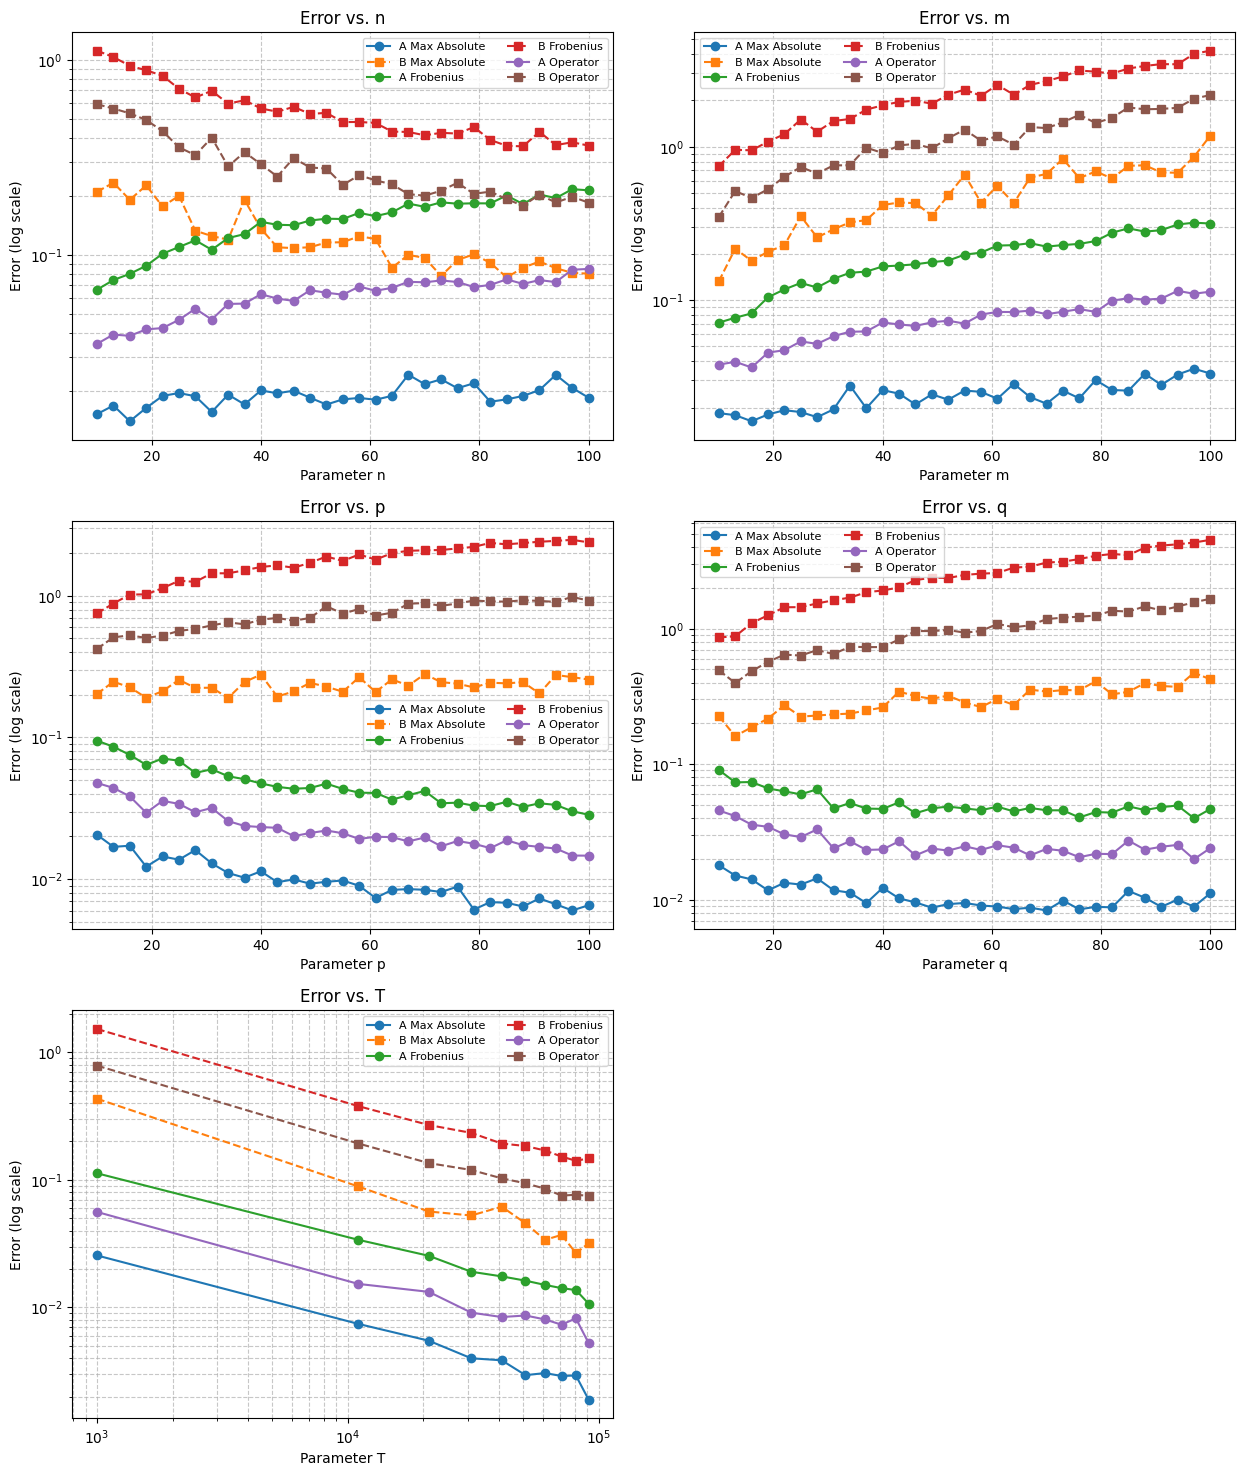


Linear Model Slopes (log-linear data):
n: A_max_abs=0.003 A_frobenius=0.011 A_operator=0.008 B_max_abs=-0.011 B_frobenius=-0.011 B_operator=-0.012 
m: A_max_abs=0.007 A_frobenius=0.015 A_operator=0.012 B_max_abs=0.018 B_frobenius=0.016 B_operator=0.016 
p: A_max_abs=-0.012 A_frobenius=-0.011 A_operator=-0.011 B_max_abs=0.002 B_frobenius=0.011 B_operator=0.008 
q: A_max_abs=-0.005 A_frobenius=-0.005 A_operator=-0.005 B_max_abs=0.008 B_frobenius=0.017 B_operator=0.013 
T: A_max_abs=-0.532 A_frobenius=-0.496 A_operator=-0.474 B_max_abs=-0.579 B_frobenius=-0.526 B_operator=-0.526 


{'n': {'A_max_abs': {'slope': 0.002718792301369637,
   'intercept': -4.114585974000149,
   'r_squared': 0.34898531851385284,
   'p_value': 0.00046715877958525276},
  'B_max_abs': {'slope': -0.011149767403537398,
   'intercept': -1.517755512409861,
   'r_squared': 0.8072595083722376,
   'p_value': 6.955103160066756e-12},
  'A_frobenius': {'slope': 0.011122678669312505,
   'intercept': -2.5462922597983244,
   'r_squared': 0.8905601724119339,
   'p_value': 1.7763568394002505e-15},
  'B_frobenius': {'slope': -0.011307073669325167,
   'intercept': -0.007500706829128845,
   'r_squared': 0.8990578630534636,
   'p_value': 4.440892098500626e-16},
  'A_operator': {'slope': 0.008168342027838742,
   'intercept': -3.254862782135692,
   'r_squared': 0.8614942093189848,
   'p_value': 5.595524044110789e-14},
  'B_operator': {'slope': -0.012003960978258888,
   'intercept': -0.6298563706425352,
   'r_squared': 0.8666200560320105,
   'p_value': 3.241851231905457e-14}},
 'm': {'A_max_abs': {'slope': 0.006

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict


def calculate_errors(true: np.ndarray, est: np.ndarray) -> Dict[str, float]:
    """Calculate error metrics between true and estimated matrices."""
    return {
        'max_abs': np.max(np.abs(true - est)),
        'frobenius': np.linalg.norm(true - est, 'fro'),
        'operator': np.linalg.norm(true - est, 2)
    }

def parameter_error_analysis():
    """Analyze error trends for matrices A and B across different parameters."""
    # Default parameter values (modify as needed)
    DEFAULTS = {
        'n': 15,            # N_ROWS_A
        'm': 13,            # M_COLS_A
        'p': 14,            # P_COLS_B
        'q': 12,            # Q_ROWS_B
        'T': 2000,          # NUM_OBSERVATIONS
        'noise': 1          # NOISE_STD
    }

    # Parameter ranges to test (modify as needed)
    PARAM_RANGES = {
        'n': np.arange(10, 101, 3),      # Vary rows in A
        'm': np.arange(10, 101, 3),      # Vary columns in A
        'p': np.arange(10, 101, 3),         # Vary columns in B
        'q': np.arange(10, 101, 3),         # Vary rows in B
        'T': np.arange(1000, 100000, 10000)  # Vary observations
    }

    # Setup visualization
    fig, axs = plt.subplots(3, 2, figsize=(15, 18))
    plt.subplots_adjust(hspace=0.2, wspace=0.15)
    metrics = [
         'max_abs', 
        'frobenius', 
        'operator']
    metric_names = [
        'Max Absolute', 
        'Frobenius', 
        'Operator']
    line_styles = {'A': '-', 'B': '--'}
    markers = {'A': 'o', 'B': 's'}

    fitted_results = {}  # Store linear fit results

    for idx, param in enumerate(['n', 'm', 'p', 'q', 'T']):
        ax_row = idx // 2
        ax_col = idx % 2
        current_ax = axs[ax_row, ax_col]
        
        errors = {f'{mat}_{m}': [] for mat in ['A', 'B'] for m in metrics}
        param_values = PARAM_RANGES[param]

        for val in param_values:
            # Generate system with current parameter value
            params = DEFAULTS.copy()
            params[param] = val
            
            # Generate matrices using your system
            A_true, B_true, hat_A, hat_B, _ = generate_full_system(
                n=params['n'],
                m=params['m'],
                p=params['p'],
                q=params['q'],
                num_obs=params['T'],
                noise_std=params['noise']
            )
            
            # Calculate and store errors
            A_err = calculate_errors(A_true, hat_A)
            B_err = calculate_errors(B_true, hat_B)
            
            for m in metrics:
                errors[f'A_{m}'].append(A_err[m])
                errors[f'B_{m}'].append(B_err[m])

        # Plot results
        fitted_results[param] = {}
        for m, m_name in zip(metrics, metric_names):
            for matrix in ['A', 'B']:
                current_ax.plot(
                    param_values, 
                    errors[f'{matrix}_{m}'],
                    linestyle=line_styles[matrix],
                    marker=markers[matrix],
                    label=f'{matrix} {m_name}'
                )
                
                # Fit linear model to log-linear data
                fit_results = fit_linear_model(param_values, np.array(errors[f'{matrix}_{m}']), param)
                fitted_results[param][f'{matrix}_{m}'] = fit_results
                
        current_ax.set_xlabel(f'Parameter {param}')
        current_ax.set_ylabel('Error (log scale)')
        current_ax.set_title(f'Error vs. {param}')
        current_ax.set_xscale('log' if param == 'T' else 'linear')
        current_ax.set_yscale('log')
        current_ax.grid(True, which='both', linestyle='--', alpha=0.7)
        current_ax.legend(ncol=2, fontsize=8)

    plt.delaxes(axs[2, 1])  # Remove empty subplot
    plt.show()
    
    # Print fitted slopes
    print("\nLinear Model Slopes (log-linear data):")
    for param in ['n', 'm', 'p', 'q', 'T']:
        print(f"{param}:", end=" ")
        for matrix in ['A', 'B']:
            for m in metrics:
                slope = fitted_results[param][f'{matrix}_{m}']['slope']
                print(f"{matrix}_{m}={slope:.3f}", end=" ")
        print()
    
    return fitted_results

# Example usage
parameter_error_analysis()

# CIFAR Dataset 

### Load data

In [21]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Check dataset shapes
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


2025-10-19 20:56:34.957613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


### Plot an example

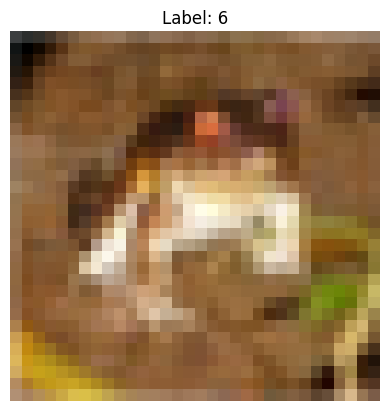

In [22]:
# Plot an example from the training set
index = 0  # Example index
plt.imshow(X_train[index])
plt.title(f"Label: {y_train[index][0]}")
plt.axis('off')
plt.show()

### Add noise

In [23]:
import numpy as np

np.random.seed(42)
# Define the noise level (adjust as needed)
noise_factor = 0.02

# Create noisy matrices for transformation
A_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
# Normalize each row to have unit L1 norm
A_noisy_L1 = A_noisy / np.abs(A_noisy).sum(axis=1, keepdims=True)
A_noisy_L1_inv = np.linalg.inv(A_noisy_L1)

B_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
B_noisy_inv = np.linalg.inv(B_noisy)

# Apply left and right multiplication to each image for all channels
def apply_noise_transform(image, A_noisy_L1, B_noisy):
    transformed_channels = [
        np.dot(np.dot(A_noisy_L1, channel), B_noisy) for channel in image.transpose(2, 0, 1)
    ]
    return np.stack(transformed_channels, axis=2)

# Apply the transformation to the training and test datasets
X_train_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_train])
X_test_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_test])

# Verify the shape of the modified datasets
print(f"Modified training data shape: {X_train_modified.shape}")
print(f"Modified test data shape: {X_test_modified.shape}")


Modified training data shape: (50000, 32, 32, 3)
Modified test data shape: (10000, 32, 32, 3)


### Plot noisy example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


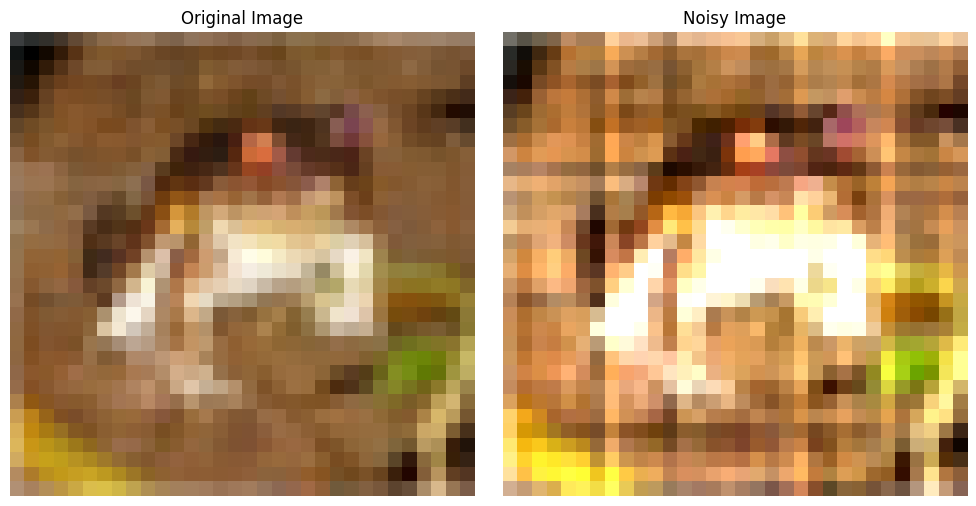

In [24]:
import matplotlib.pyplot as plt

index = 0  # Choose an image index
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(X_train[index])  # No 'cmap' needed for RGB images
plt.title("Original Image")
plt.axis('off')

# Modified image
plt.subplot(1, 2, 2)
plt.imshow(X_train_modified[index].astype('float32'))  # Ensure correct type for visualization
plt.title("Noisy Image")
plt.axis('off')

plt.tight_layout()
plt.show()


### Build estimators

In [25]:
# Reshape each channel of the CIFAR images into flattened rows
def reshape_by_channel(data):
    channels = []
    for c in range(data.shape[-1]):  # Loop through color channels (RGB)
        channel = data[..., c].reshape(data.shape[0], -1)  # Flatten each channel
        channels.append(channel)
    return channels

# Separate channels for original and modified datasets
X_train_channels = reshape_by_channel(X_train)
X_train_modified_channels = reshape_by_channel(X_train_modified)
X_test_channels = reshape_by_channel(X_test)
X_test_modified_channels = reshape_by_channel(X_test_modified)

# Initialize lists to store results for each channel
C_train_channels = []
C_test_channels = []

# Process each channel independently
for c in range(3):  # Loop through RGB channels
    # Original and modified channel matrices
    X_train_channel = X_train_channels[c]
    X_train_modified_channel = X_train_modified_channels[c]
    X_test_channel = X_test_channels[c]
    X_test_modified_channel = X_test_modified_channels[c]
    
    # Compute covariance matrices
    X_train_modified_T_X_train_modified = np.dot(X_train_modified_channel.T, X_train_modified_channel)
    X_test_modified_T_X_test_modified = np.dot(X_test_modified_channel.T, X_test_modified_channel)

    # Compute pseudo-inverse
    X_train_modified_inv = np.linalg.pinv(X_train_modified_T_X_train_modified)
    X_test_modified_inv = np.linalg.pinv(X_test_modified_T_X_test_modified)

    # Compute projection matrices
    C_train = np.dot(
        np.dot(X_train_modified_inv, X_train_modified_channel.T),
        X_train_channel
    )
    C_test = np.dot(
        np.dot(X_test_modified_inv, X_test_modified_channel.T),
        X_test_channel
    )

    # Append results for the channel
    C_train_channels.append(C_train)
    C_test_channels.append(C_test)

# Combine results for all channels if needed
C_X_train_modified_matrix_hat = np.stack(C_train_channels, axis=0)
C_X_test_modified_matrix_hat = np.stack(C_test_channels, axis=0)

# Output shapes for verification
print(f"Shape of projection matrix for training data (per channel): {C_train.shape}")
print(f"Shape of projection matrix for test data (per channel): {C_test.shape}")
print(f"Combined shape for training data: {C_X_train_modified_matrix_hat.shape}")
print(f"Combined shape for test data: {C_X_test_modified_matrix_hat.shape}")


Shape of projection matrix for training data (per channel): (1024, 1024)
Shape of projection matrix for test data (per channel): (1024, 1024)
Combined shape for training data: (3, 1024, 1024)
Combined shape for test data: (3, 1024, 1024)


In [26]:
def smallest_singular_value(matrix):
    """
    Compute the smallest singular value of a given matrix.
    """
    singular_values = np.linalg.svd(matrix, compute_uv=False)
    return np.min(singular_values)

# Compute the smallest singular value for each channel
smallest_singular_values_train = []
smallest_singular_values_test = []

for c in range(3):  # Loop through RGB channels
    # Compute for the training data
    s_train = smallest_singular_value(C_train_channels[c])
    smallest_singular_values_train.append(s_train)

    # Compute for the test data
    s_test = smallest_singular_value(C_test_channels[c])
    smallest_singular_values_test.append(s_test)

# Print the results for each channel
for c, (s_train, s_test) in enumerate(zip(smallest_singular_values_train, smallest_singular_values_test)):
    print(f"Channel {c} - Smallest Singular Value (Train): {s_train:.4e}")
    print(f"Channel {c} - Smallest Singular Value (Test): {s_test:.4e}")


Channel 0 - Smallest Singular Value (Train): 4.7939e-01
Channel 0 - Smallest Singular Value (Test): 4.7939e-01
Channel 1 - Smallest Singular Value (Train): 4.7939e-01
Channel 1 - Smallest Singular Value (Test): 4.7939e-01
Channel 2 - Smallest Singular Value (Train): 4.7939e-01
Channel 2 - Smallest Singular Value (Test): 4.7939e-01


In [27]:
from tqdm import tqdm
import numpy as np

# Initialize matrices to store results for each channel
hat_A_train_channels = []
hat_B_train_channels = []

for c in range(3):  # Loop through RGB channels
    # Extract dimensions for the current channel
    T, n, p, m, q = (X_train_modified_channels[c].shape[0],
                     32,
                     32,
                     32,
                     32)
    
    # Compute hat_A_train for the current channel
    hat_A_train = np.empty((n, m))
    for i in tqdm(range(1, n + 1), desc=f"Channel {c}: Computing hat_A_train"):
        for k in range(1, m + 1):
            numerator = np.sum(
                C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                for l in range(1, q + 1) for j in range(1, p + 1)
            )
            denominator = np.sum(
                C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                for l in range(1, q + 1) for j in range(1, p + 1)
                for k in range(1, m + 1) for i in range(1, n + 1)
            )
            tilde_A = numerator * n / denominator
            hat_A_train[i-1, k-1] = min(max(0, tilde_A), 1)
    
    hat_A_train_channels.append(hat_A_train)
    


Channel 0: Computing hat_A_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/2r/9nmfdty958xcz1d179s1fxgw0000gn/T/ipykernel_33900/4189155510.py:20: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
/var/folders/2r/9nmfdty958xcz1d179s1fxgw0000gn/T/ipykernel_33900/4189155510.py:24: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(
Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [08:30<00:00, 15.95s/it]


In [28]:
hat_B_train_channels = []  # Initialize list to store matrices for all channels

for c in range(3):  # Process all 3 channels (RGB)
    print(f"Processing channel {c} for hat_B_train")
    
    hat_B_train = np.empty((q, p))  # Initialize the matrix for the current channel
    
    for l in tqdm(range(1, q + 1), desc=f"Channel {c}: Computing hat_B_train"):
        for j in range(1, p + 1):
            numerator = np.sum(
                C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                for k in range(1, m + 1) for i in range(1, n + 1)
            )
            hat_B_train[l - 1, j - 1] = numerator / n
    
    hat_B_train_channels.append(hat_B_train)  # Add the matrix for the current channel

# Verify the size of hat_B_train_channels
print(f"Number of channels in hat_B_train_channels: {len(hat_B_train_channels)}")


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/2r/9nmfdty958xcz1d179s1fxgw0000gn/T/ipykernel_33900/472471318.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 61.56it/s]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 62.32it/s]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 61.49it/s]

Number of channels in hat_B_train_channels: 3


### Show results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


hat_A_train_channels[0].shape: (32, 32)
X_train_modified[index][..., 0].shape: (32, 32)
hat_B_train_channels[0].shape: (32, 32)
hat_A_train_channels[1].shape: (32, 32)
X_train_modified[index][..., 1].shape: (32, 32)
hat_B_train_channels[1].shape: (32, 32)
hat_A_train_channels[2].shape: (32, 32)
X_train_modified[index][..., 2].shape: (32, 32)
hat_B_train_channels[2].shape: (32, 32)


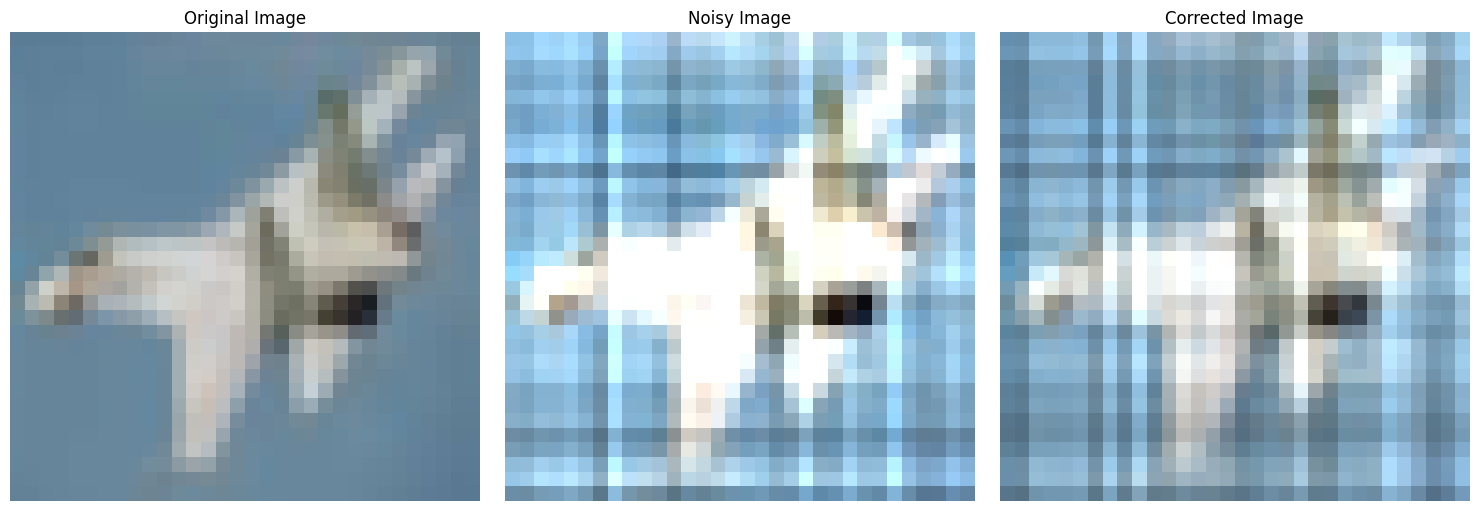

In [29]:
# Validate channel lists
assert len(hat_A_train_channels) == 3, "hat_A_train_channels does not have three channels"
assert len(hat_B_train_channels) == 3, "hat_B_train_channels does not have three channels"
index = 10

# Debug shapes
for c in range(3):
    print(f"hat_A_train_channels[{c}].shape: {hat_A_train_channels[c].shape}")
    print(f"X_train_modified[index][..., {c}].shape: {X_test_modified[index][..., c].shape}")
    print(f"hat_B_train_channels[{c}].shape: {hat_B_train_channels[c].shape}")

# Apply correction for each channel and recombine
corrected_image = np.stack(
    [
        np.dot(np.dot(hat_A_train_channels[c], X_test_modified[index][..., c]), hat_B_train_channels[c])
        for c in range(3)
    ],
    axis=-1,
)

# Clip corrected image to valid range
corrected_image = np.clip(corrected_image, 0.0, 1.0)

# Plot corrected image
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(X_test[index])
plt.title("Original Image")
plt.axis('off')

# Modified image
plt.subplot(1, 3, 2)
plt.imshow(X_test_modified[index].astype('float32'))
plt.title("Noisy Image")
plt.axis('off')

# Corrected image
plt.subplot(1, 3, 3)
plt.imshow(corrected_image)
plt.title("Corrected Image")
plt.axis('off')

plt.tight_layout()
plt.show()


In [30]:
from numpy.linalg import norm
import numpy as np

# Compute the distances for a specific index
index = 10  # Choose an image index

# Apply the correction for each channel
corrected_image = np.stack(
    [
        np.dot(np.dot(hat_A_train_channels[c], X_test_modified[index][..., c]), hat_B_train_channels[c])
        for c in range(3)
    ],
    axis=-1,
)

# Compute the Frobenius norm distances
distance_original_noisy = norm(X_test[index] - X_test_modified[index])**2
distance_original_corrected = norm(X_test[index] - corrected_image)**2

# Display the results
print(f"Distance between original and noisy image: {distance_original_noisy:.4f}")
print(f"Distance between original and corrected image: {distance_original_corrected:.4f}")


Distance between original and noisy image: 215.4360
Distance between original and corrected image: 79.8785


# Evolution of the Frobenius loss as a function of the noise factor

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm

# Define the range of noise_factor values
noise_factors = np.linspace(0.005, 0.05, 5)

# Initialize lists to store the distances for each noise_factor
distance_original_noisy_list = []
distance_original_corrected_list = []

# Process for each noise_factor
for noise_factor in noise_factors:
    # Define the noise level (adjust as needed)

    # Create noisy matrices for transformation
    A_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
    # Normalize each row to have unit L1 norm
    A_noisy_L1 = A_noisy / np.abs(A_noisy).sum(axis=1, keepdims=True)
    A_noisy_L1_inv = np.linalg.inv(A_noisy_L1)

    B_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
    B_noisy_inv = np.linalg.inv(B_noisy)

    # Apply the transformation to the training and test datasets
    X_train_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_train])
    X_test_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_test])

    # Separate channels for original and modified datasets
    X_train_channels = reshape_by_channel(X_train)
    X_train_modified_channels = reshape_by_channel(X_train_modified)
    X_test_channels = reshape_by_channel(X_test)
    X_test_modified_channels = reshape_by_channel(X_test_modified)

    # Initialize lists to store results for each channel
    C_train_channels = []
    C_test_channels = []

    # Process each channel independently
    for c in range(3):  # Loop through RGB channels
        # Original and modified channel matrices
        X_train_channel = X_train_channels[c]
        X_train_modified_channel = X_train_modified_channels[c]
        X_test_channel = X_test_channels[c]
        X_test_modified_channel = X_test_modified_channels[c]
        
        # Compute covariance matrices
        X_train_modified_T_X_train_modified = np.dot(X_train_modified_channel.T, X_train_modified_channel)
        X_test_modified_T_X_test_modified = np.dot(X_test_modified_channel.T, X_test_modified_channel)

        # Compute pseudo-inverse
        X_train_modified_inv = np.linalg.pinv(X_train_modified_T_X_train_modified)
        X_test_modified_inv = np.linalg.pinv(X_test_modified_T_X_test_modified)

        # Compute projection matrices
        C_train = np.dot(
            np.dot(X_train_modified_inv, X_train_modified_channel.T),
            X_train_channel
        )
        C_test = np.dot(
            np.dot(X_test_modified_inv, X_test_modified_channel.T),
            X_test_channel
        )

        # Append results for the channel
        C_train_channels.append(C_train)
        C_test_channels.append(C_test)

    # Combine results for all channels if needed
    C_X_train_modified_matrix_hat = np.stack(C_train_channels, axis=0)
    C_X_test_modified_matrix_hat = np.stack(C_test_channels, axis=0)

    # Initialize matrices to store results for each channel
    hat_A_train_channels = []
    hat_B_train_channels = []

    for c in range(3):  # Loop through RGB channels
        # Extract dimensions for the current channel
        T, n, p, m, q = (X_train_modified_channels[c].shape[0],
                        32,
                        32,
                        32,
                        32)
        
        # Compute hat_A_train for the current channel
        hat_A_train = np.empty((n, m))
        for i in tqdm(range(1, n + 1), desc=f"Channel {c}: Computing hat_A_train"):
            for k in range(1, m + 1):
                numerator = np.sum(
                    C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                    for l in range(1, q + 1) for j in range(1, p + 1)
                )
                denominator = np.sum(
                    C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                    for l in range(1, q + 1) for j in range(1, p + 1)
                    for k in range(1, m + 1) for i in range(1, n + 1)
                )
                x = numerator * n / denominator
                hat_A_train[i - 1, k - 1] = min(max(0, x), 1)
        
        hat_A_train_channels.append(hat_A_train)

        print(f"Processing channel {c} for hat_B_train")

        hat_B_train = np.empty((q, p))  # Initialize the matrix for the current channel
        
        for l in tqdm(range(1, q + 1), desc=f"Channel {c}: Computing hat_B_train"):
            for j in range(1, p + 1):
                numerator = np.sum(
                    C_train_channels[c][k + (l - 1) * m - 1, i + (j - 1) * n - 1]
                    for k in range(1, m + 1) for i in range(1, n + 1)
                )
                hat_B_train[l - 1, j - 1] = numerator / n
    
        hat_B_train_channels.append(hat_B_train)  # Add the matrix for the current channel

        # Verify the size of hat_B_train_channels
        print(f"Number of channels in hat_B_train_channels: {len(hat_B_train_channels)}")

    for idx in tqdm(range(len(X_test_modified))):

        # Apply the correction for each channel
        corrected_image = np.stack(
            [
                np.dot(np.dot(hat_A_train_channels[c], X_test_modified[idx][..., c]), hat_B_train_channels[c])
                for c in range(3)
            ],
            axis=-1,
        )

        # Compute the Frobenius norm distances
        distance_original_noisy = norm(X_test[idx] - X_test_modified[idx])**2
        distance_original_corrected = norm(X_test[idx] - corrected_image)**2

        # Append the results to the lists
        distance_original_noisy_list.append(distance_original_noisy)
        distance_original_corrected_list.append(distance_original_corrected)



Channel 0: Computing hat_A_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/2r/9nmfdty958xcz1d179s1fxgw0000gn/T/ipykernel_33900/695259969.py:90: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
/var/folders/2r/9nmfdty958xcz1d179s1fxgw0000gn/T/ipykernel_33900/695259969.py:94: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  denominator = np.sum(
Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [08:29<00:00, 15.94s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train:   0%|          | 0/32 [00:00<?, ?it/s]/var/folders/2r/9nmfdty958xcz1d179s1fxgw0000gn/T/ipykernel_33900/695259969.py:110: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numerator = np.sum(
Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 58.15it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [08:31<00:00, 15.99s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 59.42it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [08:38<00:00, 16.22s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 60.07it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [08:40<00:00, 16.28s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 60.96it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [25:53<00:00, 48.55s/it]   


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 61.36it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [08:28<00:00, 15.90s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 59.41it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [10:42<00:00, 20.07s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 60.49it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [08:25<00:00, 15.78s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 59.43it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [08:26<00:00, 15.83s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 59.36it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [08:22<00:00, 15.70s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 59.45it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [08:22<00:00, 15.71s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 58.10it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [08:32<00:00, 16.02s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 58.89it/s]


Number of channels in hat_B_train_channels: 3


Channel 0: Computing hat_A_train: 100%|██████████| 32/32 [08:24<00:00, 15.78s/it]


Processing channel 0 for hat_B_train


Channel 0: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 57.40it/s]


Number of channels in hat_B_train_channels: 1


Channel 1: Computing hat_A_train: 100%|██████████| 32/32 [08:30<00:00, 15.94s/it]


Processing channel 1 for hat_B_train


Channel 1: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 61.30it/s]


Number of channels in hat_B_train_channels: 2


Channel 2: Computing hat_A_train: 100%|██████████| 32/32 [08:28<00:00, 15.89s/it]


Processing channel 2 for hat_B_train


Channel 2: Computing hat_B_train: 100%|██████████| 32/32 [00:00<00:00, 58.73it/s]


Number of channels in hat_B_train_channels: 3


100%|██████████| 10000/10000 [00:00<00:00, 11640.66it/s]


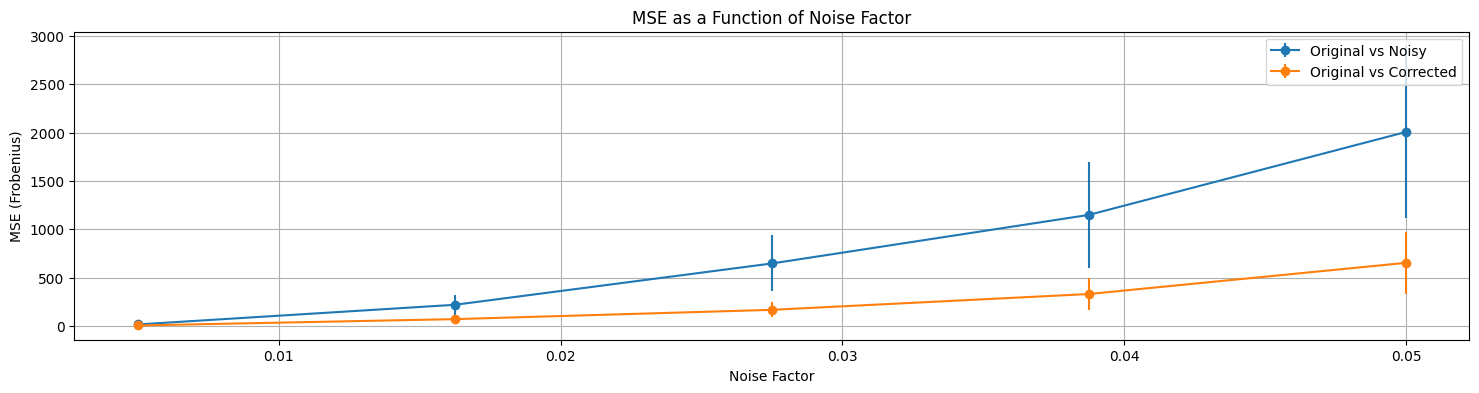

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
# Assuming distance_original_noisy_list is a flat list of length 500,000
# and noise_factor is a list of length 10
distance_original_noisy_array = np.array(distance_original_noisy_list)  # Convert to NumPy array
distance_original_corrected_array = np.array(distance_original_corrected_list)  # Convert to NumPy array
num_noise_factors = noise_factors.shape[0]  # Number of noise factor values
num_samples_per_factor = len(distance_original_noisy_array) // num_noise_factors  # Samples per noise factor

# Reshape the array into shape (num_noise_factors, num_samples_per_factor)
distance_original_noisy_array = distance_original_noisy_array.reshape(num_noise_factors, num_samples_per_factor)
distance_original_corrected_array = distance_original_corrected_array.reshape(num_noise_factors, num_samples_per_factor)

# Compute the mean and standard deviation for each noise factor
mean_distances_original_noisy = np.mean(distance_original_noisy_array, axis=1)
std_distances_original_noisy = np.std(distance_original_noisy_array, axis=1)
mean_distances_original_corrected = np.mean(distance_original_corrected_array, axis=1)
std_distances_original_corrected = np.std(distance_original_corrected_array, axis=1)

# Plot the results
plt.figure(figsize=(18, 4))
plt.errorbar(list(noise_factors), list(mean_distances_original_noisy), yerr=list(std_distances_original_noisy), fmt='o-', label='Original vs Noisy')
plt.errorbar(list(noise_factors), list(mean_distances_original_corrected), yerr=list(std_distances_original_corrected), fmt='o-', label='Original vs Corrected')
plt.xlabel("Noise Factor")
plt.ylabel("MSE (Frobenius)")
plt.title("MSE as a Function of Noise Factor")
plt.grid(True)
plt.legend()
plt.show()


In [33]:
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm

noise_factors = np.linspace(0.005, 0.05, 5)

# Per-factor aggregates we will fill
mean_F_noisy, std_F_noisy = [], []
mean_F_corrected, std_F_corrected = [], []

mean_max_noisy, std_max_noisy = [], []
mean_max_corrected, std_max_corrected = [], []

# SNR (Frobenius) per factor (in dB)
snr_db_per_factor = []

for noise_factor in noise_factors:
    # --- construct A*, B* perturbations and noisy datasets (same as your code) ---
    A_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
    A_noisy_L1 = A_noisy / np.abs(A_noisy).sum(axis=1, keepdims=True)
    A_noisy_L1_inv = np.linalg.inv(A_noisy_L1)

    B_noisy = np.eye(32) + noise_factor * np.random.normal(size=(32, 32))
    B_noisy_inv = np.linalg.inv(B_noisy)

    X_train_modified = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_train])
    X_test_modified  = np.array([apply_noise_transform(img, A_noisy_L1_inv, B_noisy_inv) for img in X_test])

    # --- channel reshape (same helpers you already use) ---
    X_train_channels = reshape_by_channel(X_train)
    X_train_modified_channels = reshape_by_channel(X_train_modified)
    X_test_channels  = reshape_by_channel(X_test)
    X_test_modified_channels = reshape_by_channel(X_test_modified)

    # --- build C matrices per channel (unchanged core logic) ---
    C_train_channels, C_test_channels = [], []
    for c in range(3):
        Xt_mod = X_train_modified_channels[c]
        Xt     = X_train_channels[c]
        Xs_mod = X_test_modified_channels[c]
        Xs     = X_test_channels[c]

        Gt = Xt_mod.T @ Xt_mod
        Gs = Xs_mod.T @ Xs_mod
        Gt_inv = np.linalg.pinv(Gt)
        Gs_inv = np.linalg.pinv(Gs)

        C_train = Gt_inv @ Xt_mod.T @ Xt
        C_test  = Gs_inv @ Xs_mod.T  @ Xs
        C_train_channels.append(C_train)
        C_test_channels.append(C_test)

    # --- estimate A_hat, B_hat per channel (your estimators) ---
    hat_A_train_channels, hat_B_train_channels = [], []
    n = m = p = q = 32

    for c in range(3):
        C = C_train_channels[c]

        # --- \hat B ---
        hat_B = np.empty((q, p))
        for l in range(1, q + 1):
            for j in range(1, p + 1):
                num = 0.0
                for k in range(1, m + 1):
                    for i in range(1, n + 1):
                        row_CC = k + (l - 1) * m - 1
                        col_CC = i + (j - 1) * n - 1
                        num += C[row_CC, col_CC]
                hat_B[l - 1, j - 1] = num / n
        hat_B_train_channels.append(hat_B)

        # --- \hat A ---
        hat_A = np.empty((n, m))
        for i in range(1, n + 1):
            for k in range(1, m + 1):
                num = 0.0
                den = 0.0
                for l in range(1, q + 1):
                    for j in range(1, p + 1):
                        row_CC = k + (l - 1) * m - 1
                        col_CC = i + (j - 1) * n - 1
                        num += C[row_CC, col_CC]
                        den += hat_B[l - 1, j - 1]
                x = num / den
                hat_A[i - 1, k - 1] = min(max(0, x), 1)
        hat_A_train_channels.append(hat_A)

    # --- evaluate on test set; collect Frobenius + max norms and SNR inputs ---
    F_noisy, F_corrected = [], []
    max_noisy, max_corrected = [], []
    signal_F_list, noise_F_list = [], []

    for idx in range(len(X_test_modified)):
        # corrected image
        corrected = np.stack(
            [hat_A_train_channels[c] @ X_test_modified[idx][..., c] @ hat_B_train_channels[c]
             for c in range(3)],
            axis=-1,
        )

        # Frobenius distances
        F_noisy.append( norm(X_test[idx] - X_test_modified[idx]) )        # ||X - X_noisy||_F
        F_corrected.append( norm(X_test[idx] - corrected) )               # ||X - X_corr||_F

        # Max-norm (element-wise infinity norm) distances
        max_noisy.append(   np.max(np.abs(X_test[idx] - X_test_modified[idx])) )
        max_corrected.append(np.max(np.abs(X_test[idx] - corrected)) )

        # For SNR (Frobenius): signal = ||X||_F, noise = ||X - X_noisy||_F
        signal_F_list.append( norm(X_test[idx]) )
        noise_F_list.append(  norm(X_test[idx] - X_test_modified[idx]) )

    # --- aggregate per factor ---
    F_noisy  = np.array(F_noisy);  F_corrected  = np.array(F_corrected)
    max_noisy = np.array(max_noisy); max_corrected = np.array(max_corrected)

    mean_F_noisy.append(F_noisy.mean());           std_F_noisy.append(F_noisy.std())
    mean_F_corrected.append(F_corrected.mean());   std_F_corrected.append(F_corrected.std())

    mean_max_noisy.append(max_noisy.mean());           std_max_noisy.append(max_noisy.std())
    mean_max_corrected.append(max_corrected.mean());   std_max_corrected.append(max_corrected.std())

    # --- SNR in dB (use per-image ratio then average in dB for stability) ---
    signal_F = np.array(signal_F_list)
    noise_F  = np.array(noise_F_list)
    snr_db   = 20.0 * np.log10( signal_F / (noise_F + 1e-12) )
    snr_db_per_factor.append(snr_db.mean())

# Convert lists to arrays
snr_db_per_factor = np.array(snr_db_per_factor)
mean_F_noisy, std_F_noisy = np.array(mean_F_noisy), np.array(std_F_noisy)
mean_F_corrected, std_F_corrected = np.array(mean_F_corrected), np.array(std_F_corrected)
mean_max_noisy, std_max_noisy = np.array(mean_max_noisy), np.array(std_max_noisy)
mean_max_corrected, std_max_corrected = np.array(mean_max_corrected), np.array(std_max_corrected)


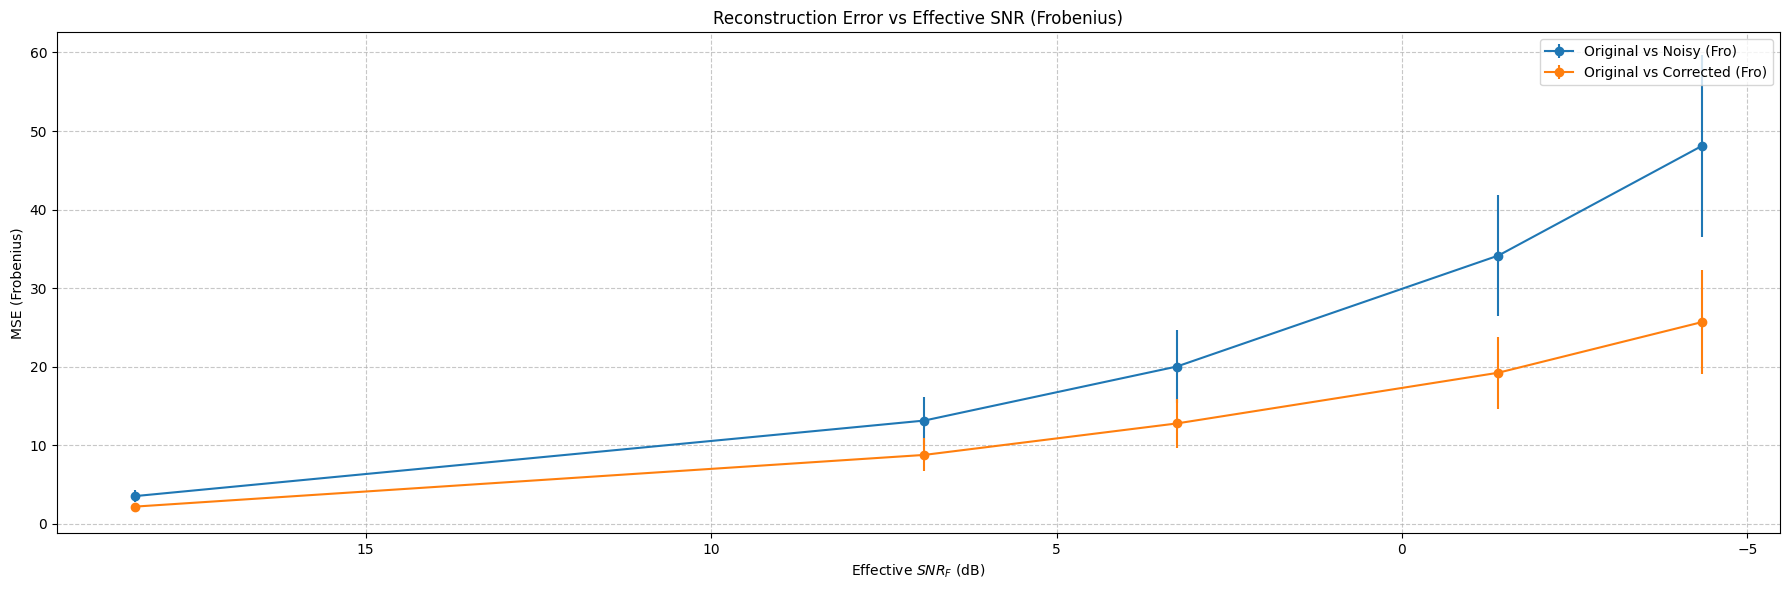

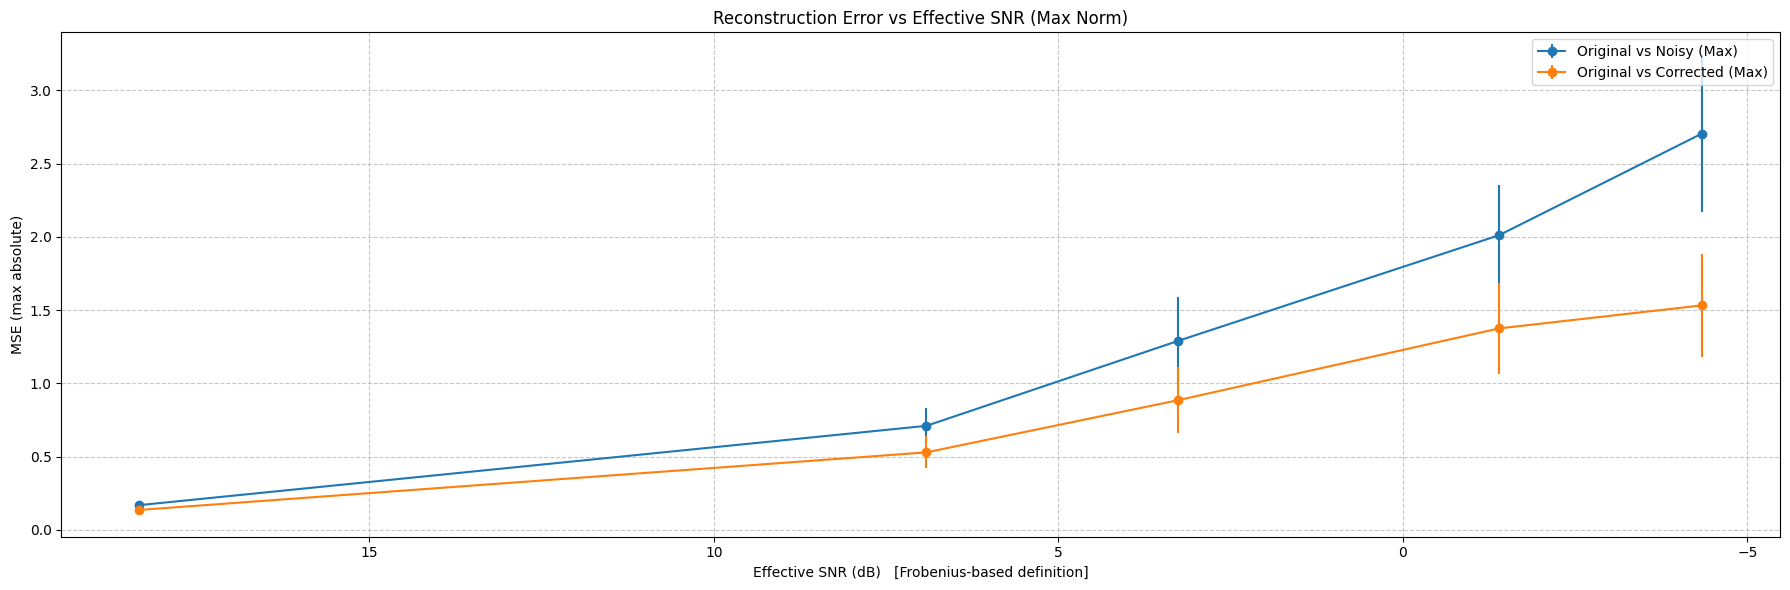

In [39]:
import matplotlib.pyplot as plt

# --- Frobenius norm vs SNR(dB) ---
plt.figure(figsize=(18, 6))
plt.errorbar(snr_db_per_factor, mean_F_noisy,     yerr=std_F_noisy,     fmt='o-', label='Original vs Noisy (Fro)')
plt.errorbar(snr_db_per_factor, mean_F_corrected, yerr=std_F_corrected, fmt='o-', label='Original vs Corrected (Fro)')
plt.gca().invert_xaxis()  # higher SNR (left) -> lower error (visual convention), optional
plt.xlabel(r'Effective $SNR_F$ (dB)')
plt.ylabel('MSE (Frobenius)')
plt.title('Reconstruction Error vs Effective SNR (Frobenius)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# --- Element-wise max norm vs SNR(dB) ---
plt.figure(figsize=(18, 6))
plt.errorbar(snr_db_per_factor, mean_max_noisy,     yerr=std_max_noisy,     fmt='o-', label='Original vs Noisy (Max)')
plt.errorbar(snr_db_per_factor, mean_max_corrected, yerr=std_max_corrected, fmt='o-', label='Original vs Corrected (Max)')
plt.gca().invert_xaxis()
plt.xlabel('Effective SNR (dB)   [Frobenius-based definition]')
plt.ylabel('MSE (max absolute)')
plt.title('Reconstruction Error vs Effective SNR (Max Norm)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()
